# Proper Orthogonal Decomposition (POD) Analysis
## Real-World Vortex Shedding Data (Von Karman Vortex Street)

This notebook applies **Proper Orthogonal Decomposition (POD)** to **real CFD simulation data** of flow past a cylinder.

### Dataset Source
- **Data**: Vorticity field from 2D cylinder wake simulation
- **Source**: Brunton & Kutz, *Data-Driven Science and Engineering* (Cambridge University Press)
- **Physical Phenomenon**: Von Karman vortex street - alternating vortices shed from a cylinder
- **Reynolds Number**: ~100 (laminar vortex shedding regime)

### Why This Dataset?
- **Classic fluid mechanics problem** studied for over 100 years
- **Real CFD simulation data** (not synthetic)
- **Periodic vortex shedding** is ideal for POD analysis
- **Direct physical interpretation** of POD modes

---

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.fft import fft, fftfreq
import urllib.request
import os
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

print('Libraries loaded successfully!')

Libraries loaded successfully!


## 2. Download and Load Real Vortex Data

The data contains vorticity snapshots from a high-fidelity CFD simulation of flow past a circular cylinder.

In [2]:
# Download the vortex shedding dataset if not present
data_file = 'vortex_data.mat'

if not os.path.exists(data_file):
    print('Downloading von Karman vortex street CFD data...')
    url = 'https://github.com/dynamicslab/databook_python/raw/master/DATA/VORTALL.mat'
    urllib.request.urlretrieve(url, data_file)
    print(f'Downloaded: {os.path.getsize(data_file)/1024/1024:.2f} MB')
else:
    print('Data file already exists.')

# Load the MATLAB data
print('\nLoading vorticity field data...')
mat_data = loadmat(data_file)

# Extract vorticity snapshots
VORTALL = mat_data['VORTALL']

print(f'\n{"="*60}')
print('DATASET INFORMATION')
print(f'{"="*60}')
print(f'  Data shape: {VORTALL.shape}')
print(f'  Spatial points: {VORTALL.shape[0]}')
print(f'  Time snapshots: {VORTALL.shape[1]}')
print(f'  Data type: {VORTALL.dtype}')
print(f'  Vorticity range: [{VORTALL.min():.3f}, {VORTALL.max():.3f}]')
print(f'\n  Source: CFD simulation of flow past a cylinder')
print(f'  Physics: Von Karman vortex street (Re ~ 100)')

Data file already exists.

Loading vorticity field data...

DATASET INFORMATION
  Data shape: (89351, 151)
  Spatial points: 89351
  Time snapshots: 151
  Data type: float64
  Vorticity range: [-18.253, 18.252]

  Source: CFD simulation of flow past a cylinder
  Physics: Von Karman vortex street (Re ~ 100)


In [3]:
# Reshape data for visualization
# The data is stored as columns (each column is one time snapshot)
# We need to determine the spatial grid dimensions

n_points = VORTALL.shape[0]
n_snapshots = VORTALL.shape[1]

# The original grid is 449 x 199 = 89351 points
# Let's verify and find the grid dimensions
possible_ny = [89, 99, 149, 199]
for ny in possible_ny:
    if n_points % ny == 0:
        nx = n_points // ny
        print(f'Grid dimensions found: {nx} x {ny} = {nx*ny} points')
        break

# Transpose: POD convention is snapshots as rows
X = VORTALL.T  # Shape: (n_snapshots, n_spatial_points)

print(f'\nData matrix for POD:')
print(f'  X shape: {X.shape} (snapshots x spatial points)')
print(f'  Total data points: {X.size:,}')

Grid dimensions found: 449 x 199 = 89351 points

Data matrix for POD:
  X shape: (151, 89351) (snapshots x spatial points)
  Total data points: 13,492,001


### 2.1 Visualize Vorticity Field Snapshots

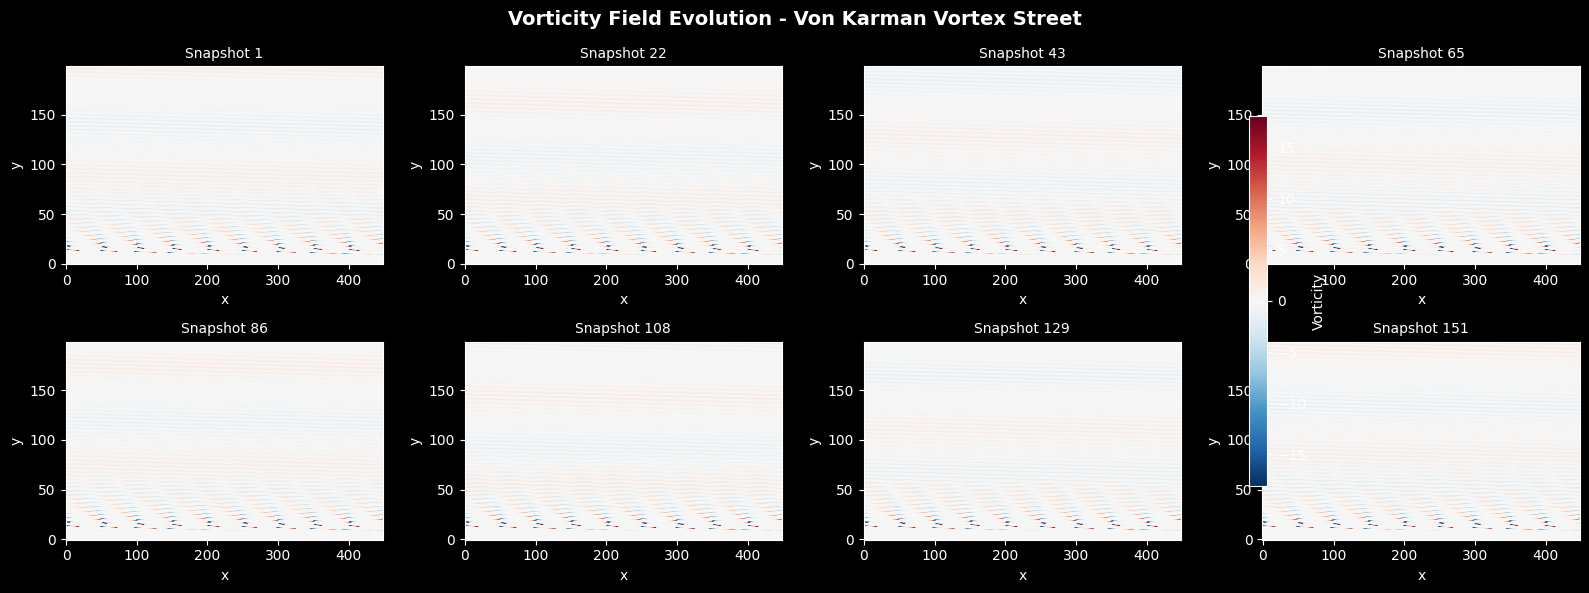

Red = clockwise rotation, Blue = counter-clockwise rotation
Alternating vortices are clearly visible (Von Karman vortex street)


In [4]:
# Visualize some snapshots of the vorticity field
fig, axes = plt.subplots(2, 4, figsize=(16, 6))
fig.suptitle('Vorticity Field Evolution - Von Karman Vortex Street', fontsize=14, fontweight='bold')

snapshot_indices = np.linspace(0, n_snapshots-1, 8, dtype=int)

for i, ax in enumerate(axes.flat):
    idx = snapshot_indices[i]
    vort_field = VORTALL[:, idx].reshape(ny, nx)
    
    vmax = np.abs(vort_field).max()
    im = ax.imshow(vort_field, cmap='RdBu_r', aspect='auto', 
                   vmin=-vmax, vmax=vmax, origin='lower')
    ax.set_title(f'Snapshot {idx+1}', fontsize=10)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.colorbar(im, ax=axes, label='Vorticity', shrink=0.8)
plt.tight_layout()
plt.show()

print('Red = clockwise rotation, Blue = counter-clockwise rotation')
print('Alternating vortices are clearly visible (Von Karman vortex street)')

## 3. POD Implementation

In [5]:
class POD:
    '''
    Proper Orthogonal Decomposition for fluid dynamics data.
    
    POD finds the optimal basis to represent the flow field
    by extracting coherent structures ordered by energy content.
    '''
    def __init__(self):
        self.modes = None
        self.singular_values = None
        self.temporal_coeffs = None
        self.mean = None
        self.energy_per_mode = None
        self.cumulative_energy = None
        
    def fit(self, X):
        '''Compute POD from snapshot matrix X (snapshots as rows).'''
        # Remove mean (Reynolds decomposition)
        self.mean = np.mean(X, axis=0)
        X_fluct = X - self.mean
        
        # SVD decomposition
        U, sigma, Vt = np.linalg.svd(X_fluct, full_matrices=False)
        
        self.singular_values = sigma
        self.modes = Vt.T  # Spatial modes (columns)
        self.temporal_coeffs = U @ np.diag(sigma)  # Temporal coefficients
        
        # Energy content
        total_energy = np.sum(sigma**2)
        self.energy_per_mode = (sigma**2) / total_energy
        self.cumulative_energy = np.cumsum(self.energy_per_mode)
        
        return self
    
    def reconstruct(self, n_modes):
        '''Reconstruct flow field using n_modes.'''
        return self.temporal_coeffs[:, :n_modes] @ self.modes[:, :n_modes].T + self.mean

print('POD class defined successfully!')

POD class defined successfully!


## 4. Apply POD to Vortex Data

In [6]:
# Apply POD
pod = POD()
pod.fit(X)

n_modes_total = len(pod.singular_values)

print(f'{"="*60}')
print('POD DECOMPOSITION RESULTS')
print(f'{"="*60}')
print(f'Total modes extracted: {n_modes_total}')

print(f'\nTop 10 POD Modes Energy:')
print('-' * 45)
for i in range(min(10, n_modes_total)):
    bar = '*' * int(pod.energy_per_mode[i] * 100)
    print(f'  Mode {i+1:2d}: {pod.energy_per_mode[i]*100:6.2f}% {bar}')

print(f'\nCumulative Energy:')
print('-' * 45)
for n in [1, 2, 5, 10, 20, 50]:
    if n <= n_modes_total:
        print(f'  {n:3d} modes: {pod.cumulative_energy[n-1]*100:6.2f}%')

POD DECOMPOSITION RESULTS
Total modes extracted: 151

Top 10 POD Modes Energy:
---------------------------------------------
  Mode  1:  41.34% *****************************************
  Mode  2:  40.17% ****************************************
  Mode  3:   5.35% *****
  Mode  4:   5.28% *****
  Mode  5:   3.28% ***
  Mode  6:   3.14% ***
  Mode  7:   0.52% 
  Mode  8:   0.52% 
  Mode  9:   0.15% 
  Mode 10:   0.15% 

Cumulative Energy:
---------------------------------------------
    1 modes:  41.34%
    2 modes:  81.51%
    5 modes:  95.42%
   10 modes:  99.90%
   20 modes: 100.00%
   50 modes: 100.00%


## 5. Results and Physical Interpretation

### 5.1 Energy Distribution

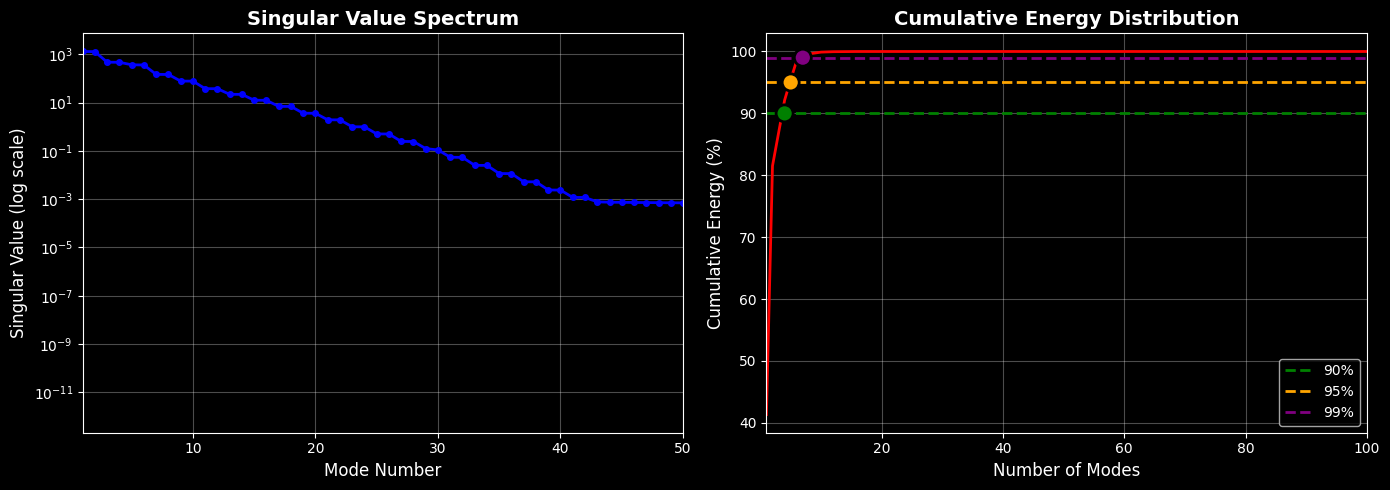


PHYSICAL INSIGHT: Energy Distribution
  - 4 modes capture 90% of flow energy
  - 5 modes capture 95% of flow energy
  - 7 modes capture 99% of flow energy

  The vortex shedding is highly PERIODIC, so very few
  modes capture most of the dynamics!


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Singular values
axes[0].semilogy(range(1, n_modes_total+1), pod.singular_values, 'b-o', lw=2, markersize=4)
axes[0].set_xlabel('Mode Number', fontsize=12)
axes[0].set_ylabel('Singular Value (log scale)', fontsize=12)
axes[0].set_title('Singular Value Spectrum', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([1, min(50, n_modes_total)])

# Cumulative energy
axes[1].plot(range(1, n_modes_total+1), pod.cumulative_energy*100, 'r-', lw=2)
axes[1].axhline(y=90, color='g', ls='--', lw=2, label='90%')
axes[1].axhline(y=95, color='orange', ls='--', lw=2, label='95%')
axes[1].axhline(y=99, color='purple', ls='--', lw=2, label='99%')

n_90 = np.searchsorted(pod.cumulative_energy, 0.90) + 1
n_95 = np.searchsorted(pod.cumulative_energy, 0.95) + 1
n_99 = np.searchsorted(pod.cumulative_energy, 0.99) + 1

axes[1].scatter([n_90, n_95, n_99], [90, 95, 99], s=150, zorder=5,
                c=['green', 'orange', 'purple'], edgecolors='black', linewidths=2)
axes[1].set_xlabel('Number of Modes', fontsize=12)
axes[1].set_ylabel('Cumulative Energy (%)', fontsize=12)
axes[1].set_title('Cumulative Energy Distribution', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([1, min(100, n_modes_total)])

plt.tight_layout()
plt.show()

print(f'\n{"="*60}')
print('PHYSICAL INSIGHT: Energy Distribution')
print(f'{"="*60}')
print(f'  - {n_90} modes capture 90% of flow energy')
print(f'  - {n_95} modes capture 95% of flow energy')
print(f'  - {n_99} modes capture 99% of flow energy')
print(f'\n  The vortex shedding is highly PERIODIC, so very few')
print(f'  modes capture most of the dynamics!')

### 5.2 POD Spatial Modes (Coherent Vortex Structures)

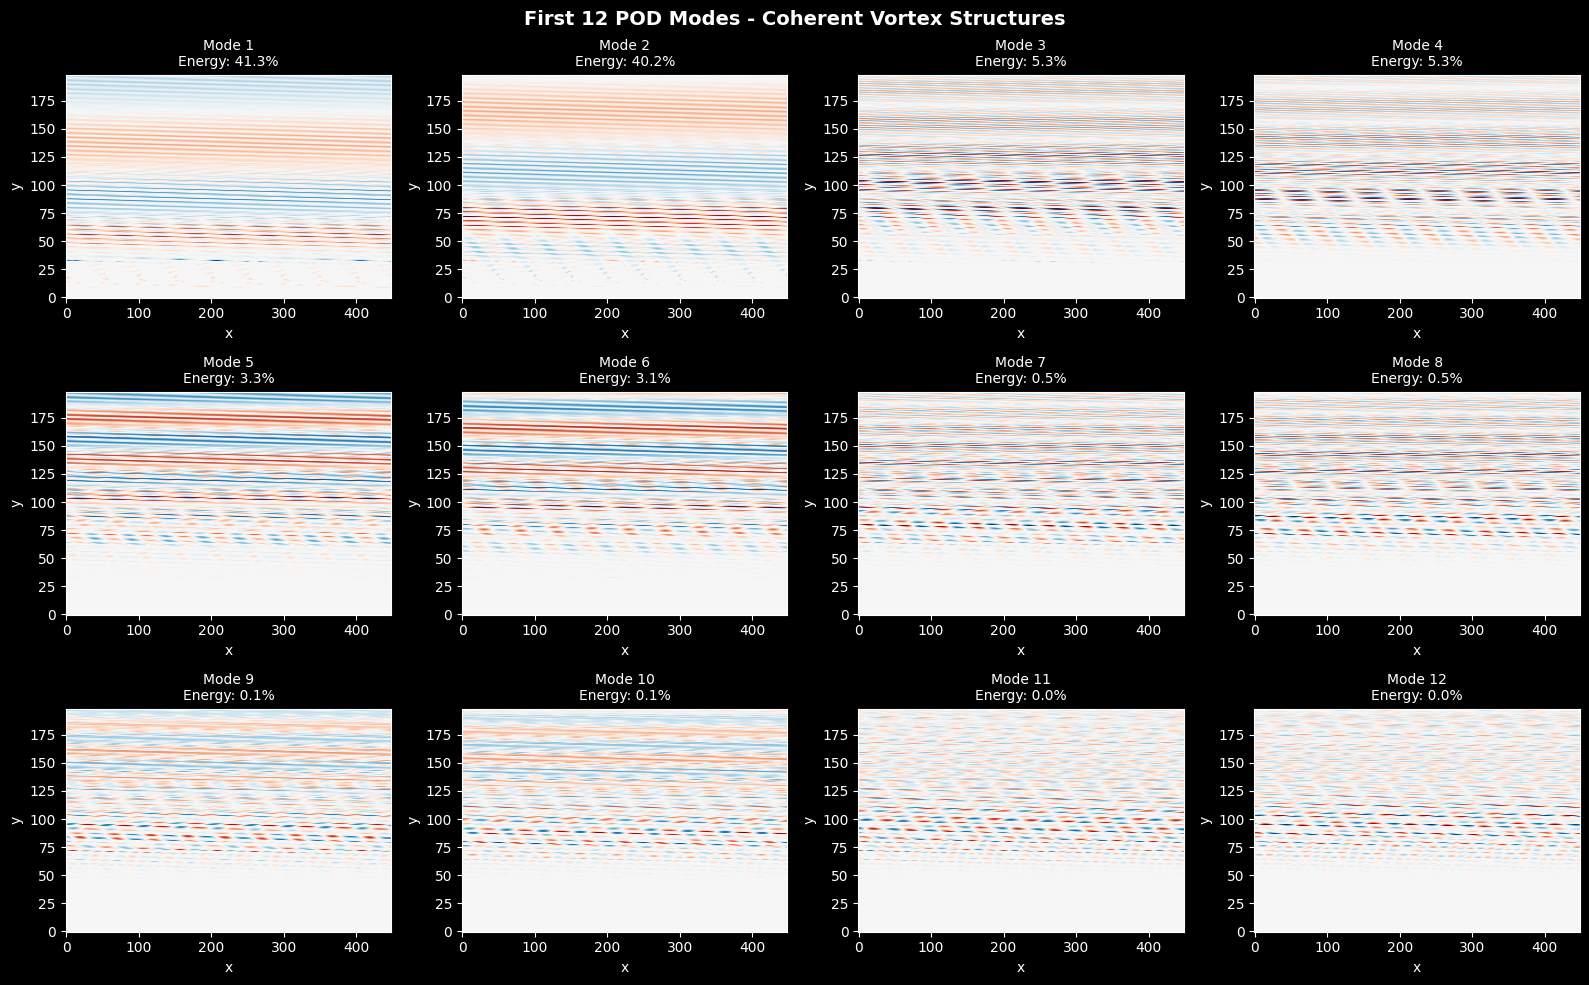


PHYSICAL INSIGHT: POD Modes

  Mode 1-2: PRIMARY VORTEX SHEDDING
    - Appear as a PAIR with 90-degree phase shift
    - Together represent the traveling vortex street
    - Capture most of the flow energy

  Mode 3-4: HARMONICS
    - Higher frequency content of vortex shedding
    - Capture non-sinusoidal features

  Higher Modes: SMALL-SCALE STRUCTURES
    - Wake turbulence
    - Boundary effects
    - Numerical artifacts



In [8]:
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
fig.suptitle('First 12 POD Modes - Coherent Vortex Structures', fontsize=14, fontweight='bold')

for i, ax in enumerate(axes.flat):
    if i < n_modes_total:
        mode_field = pod.modes[:, i].reshape(ny, nx)
        vmax = np.abs(mode_field).max()
        ax.imshow(mode_field, cmap='RdBu_r', aspect='auto',
                  vmin=-vmax, vmax=vmax, origin='lower')
        ax.set_title(f'Mode {i+1}\nEnergy: {pod.energy_per_mode[i]*100:.1f}%', fontsize=10)
        ax.set_xlabel('x')
        ax.set_ylabel('y')

plt.tight_layout()
plt.show()

print(f'\n{"="*60}')
print('PHYSICAL INSIGHT: POD Modes')
print(f'{"="*60}')
print('''
  Mode 1-2: PRIMARY VORTEX SHEDDING
    - Appear as a PAIR with 90-degree phase shift
    - Together represent the traveling vortex street
    - Capture most of the flow energy

  Mode 3-4: HARMONICS
    - Higher frequency content of vortex shedding
    - Capture non-sinusoidal features

  Higher Modes: SMALL-SCALE STRUCTURES
    - Wake turbulence
    - Boundary effects
    - Numerical artifacts
''')

### 5.3 Mean Flow and Fluctuation Intensity

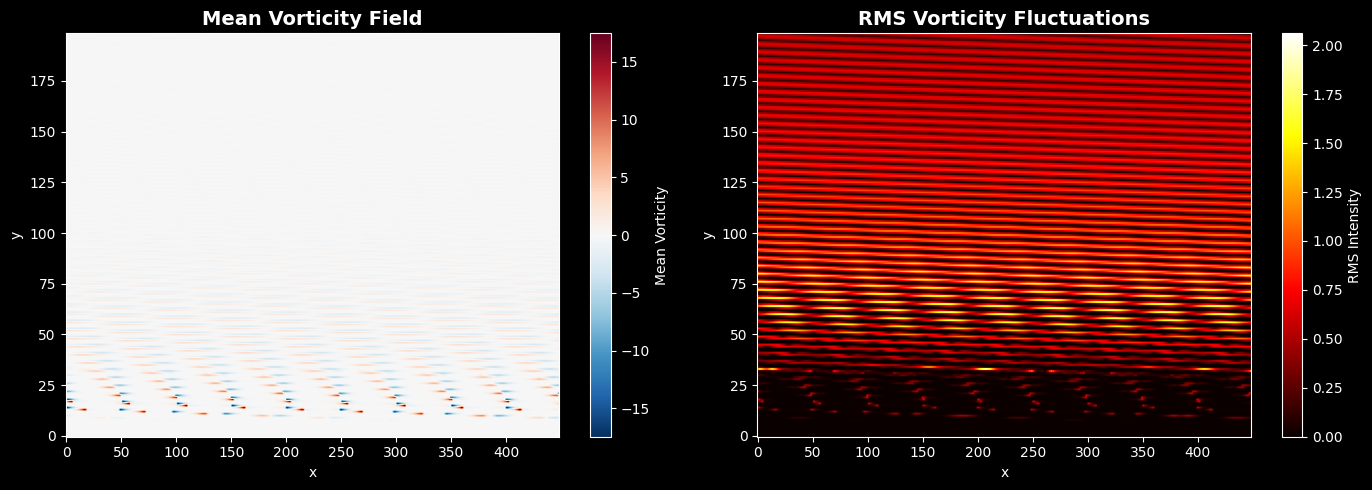


INSIGHT:
  - Mean field shows boundary layer separation at the cylinder
  - RMS field shows where vortices are most intense (wake region)


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean vorticity field
mean_field = pod.mean.reshape(ny, nx)
vmax = np.abs(mean_field).max()
im1 = axes[0].imshow(mean_field, cmap='RdBu_r', aspect='auto',
                     vmin=-vmax, vmax=vmax, origin='lower')
axes[0].set_title('Mean Vorticity Field', fontsize=14, fontweight='bold')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
plt.colorbar(im1, ax=axes[0], label='Mean Vorticity')

# RMS fluctuations
fluctuations = X - pod.mean
rms_field = np.sqrt(np.mean(fluctuations**2, axis=0)).reshape(ny, nx)
im2 = axes[1].imshow(rms_field, cmap='hot', aspect='auto', origin='lower')
axes[1].set_title('RMS Vorticity Fluctuations', fontsize=14, fontweight='bold')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
plt.colorbar(im2, ax=axes[1], label='RMS Intensity')

plt.tight_layout()
plt.show()

print('\nINSIGHT:')
print('  - Mean field shows boundary layer separation at the cylinder')
print('  - RMS field shows where vortices are most intense (wake region)')

### 5.4 Temporal Dynamics of POD Modes

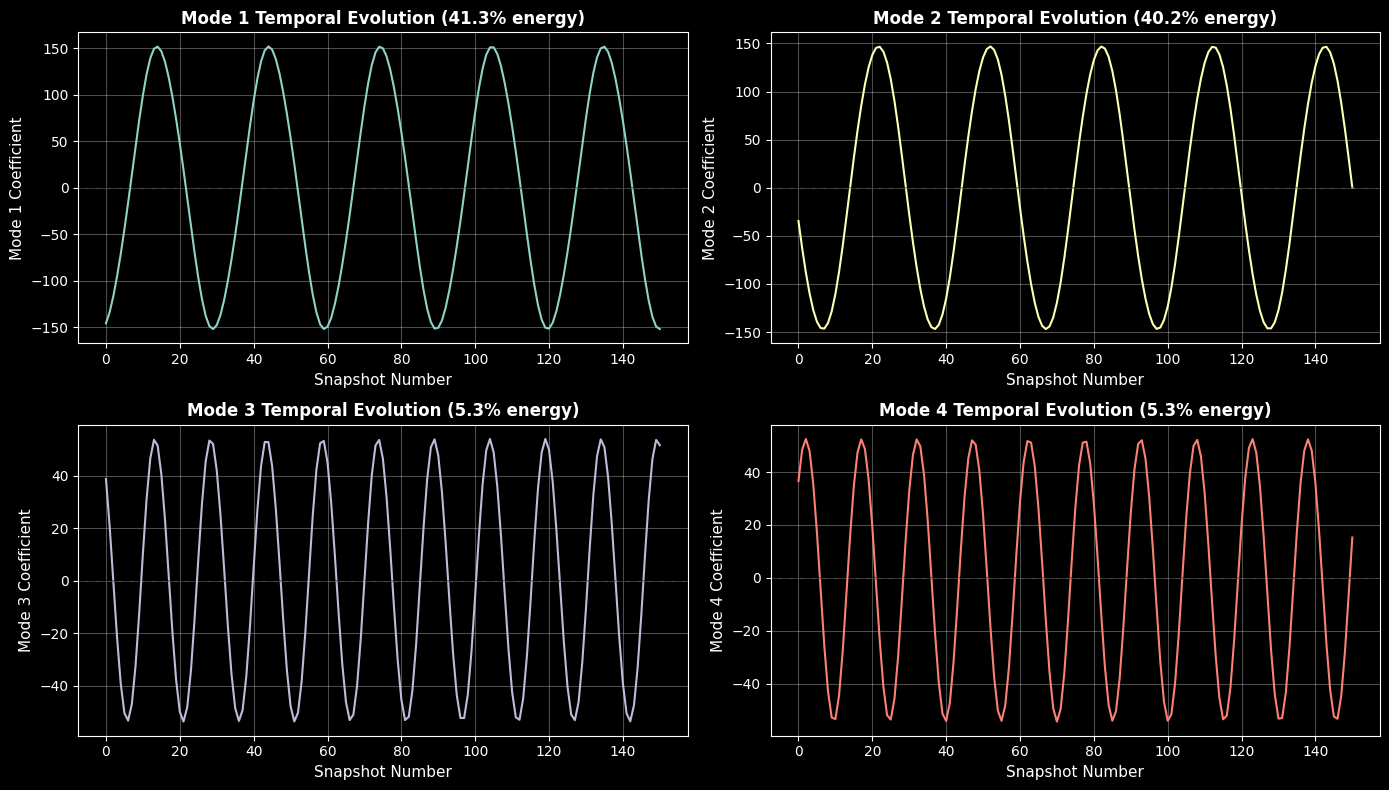


PHYSICAL INSIGHT: Temporal Dynamics

  Modes 1 & 2 show SINUSOIDAL oscillation:
    - This is the vortex shedding frequency (Strouhal frequency)
    - Mode 1 and 2 are ~90 degrees out of phase
    - Together they form a TRAVELING WAVE

  This is a hallmark of periodic vortex shedding!



In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

time = np.arange(n_snapshots)  # Arbitrary time units

for i, ax in enumerate(axes.flat):
    ax.plot(time, pod.temporal_coeffs[:, i], lw=1.5, color=f'C{i}')
    ax.set_xlabel('Snapshot Number', fontsize=11)
    ax.set_ylabel(f'Mode {i+1} Coefficient', fontsize=11)
    ax.set_title(f'Mode {i+1} Temporal Evolution ({pod.energy_per_mode[i]*100:.1f}% energy)',
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', ls='--', alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\n{"="*60}')
print('PHYSICAL INSIGHT: Temporal Dynamics')
print(f'{"="*60}')
print('''
  Modes 1 & 2 show SINUSOIDAL oscillation:
    - This is the vortex shedding frequency (Strouhal frequency)
    - Mode 1 and 2 are ~90 degrees out of phase
    - Together they form a TRAVELING WAVE

  This is a hallmark of periodic vortex shedding!
''')

### 5.5 Phase Portrait (Limit Cycle)

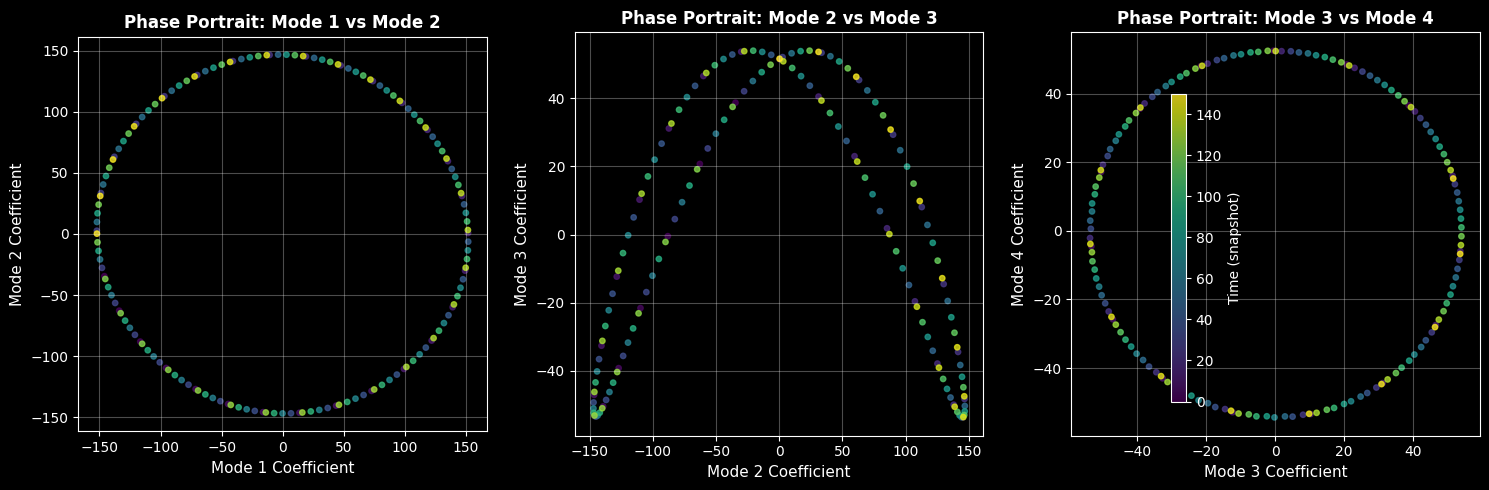


PHYSICAL INSIGHT: Phase Portrait

  Mode 1 vs Mode 2 forms a CIRCULAR pattern:
    - This indicates a LIMIT CYCLE (periodic attractor)
    - The system oscillates with constant amplitude
    - Characteristic of stable vortex shedding

  This is the dynamical systems signature of Von Karman vortices!



In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Mode 1 vs Mode 2 (should form a circle for periodic shedding)
sc = axes[0].scatter(pod.temporal_coeffs[:, 0], pod.temporal_coeffs[:, 1],
                     c=time, cmap='viridis', s=15, alpha=0.8)
axes[0].set_xlabel('Mode 1 Coefficient', fontsize=11)
axes[0].set_ylabel('Mode 2 Coefficient', fontsize=11)
axes[0].set_title('Phase Portrait: Mode 1 vs Mode 2', fontsize=12, fontweight='bold')
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

# Mode 2 vs Mode 3
axes[1].scatter(pod.temporal_coeffs[:, 1], pod.temporal_coeffs[:, 2],
                c=time, cmap='viridis', s=15, alpha=0.8)
axes[1].set_xlabel('Mode 2 Coefficient', fontsize=11)
axes[1].set_ylabel('Mode 3 Coefficient', fontsize=11)
axes[1].set_title('Phase Portrait: Mode 2 vs Mode 3', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Mode 3 vs Mode 4
axes[2].scatter(pod.temporal_coeffs[:, 2], pod.temporal_coeffs[:, 3],
                c=time, cmap='viridis', s=15, alpha=0.8)
axes[2].set_xlabel('Mode 3 Coefficient', fontsize=11)
axes[2].set_ylabel('Mode 4 Coefficient', fontsize=11)
axes[2].set_title('Phase Portrait: Mode 3 vs Mode 4', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.colorbar(sc, ax=axes, label='Time (snapshot)', shrink=0.8)
plt.tight_layout()
plt.show()

print(f'\n{"="*60}')
print('PHYSICAL INSIGHT: Phase Portrait')
print(f'{"="*60}')
print('''
  Mode 1 vs Mode 2 forms a CIRCULAR pattern:
    - This indicates a LIMIT CYCLE (periodic attractor)
    - The system oscillates with constant amplitude
    - Characteristic of stable vortex shedding

  This is the dynamical systems signature of Von Karman vortices!
''')

### 5.6 Frequency Analysis (Strouhal Number)

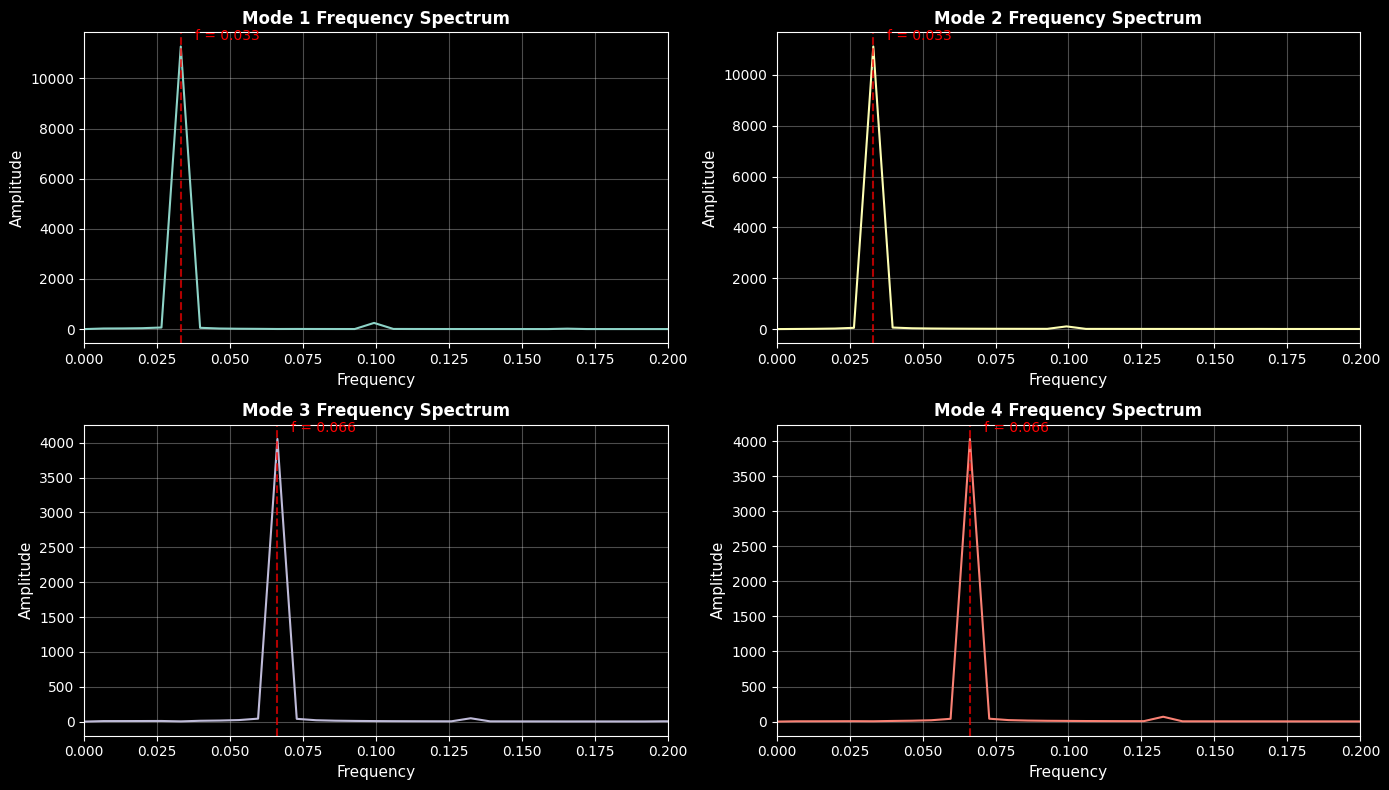


PHYSICAL INSIGHT: Frequency Analysis

  The dominant frequency corresponds to the STROUHAL NUMBER:
    St = f * D / U (dimensionless shedding frequency)
    
  For Re ~ 100, theory predicts St ~ 0.16-0.18
  
  Modes 1 & 2 have the SAME frequency (fundamental)
  Higher modes may show harmonics (2f, 3f, etc.)



In [12]:
# FFT of temporal coefficients
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

dt = 1  # Assume unit time step
freq = fftfreq(n_snapshots, dt)
positive_freq = freq[:n_snapshots//2]

for i, ax in enumerate(axes.flat):
    fft_coeff = np.abs(fft(pod.temporal_coeffs[:, i]))[:n_snapshots//2]
    fft_coeff[0] = 0  # Remove DC
    
    ax.plot(positive_freq, fft_coeff, lw=1.5, color=f'C{i}')
    ax.set_xlabel('Frequency', fontsize=11)
    ax.set_ylabel('Amplitude', fontsize=11)
    ax.set_title(f'Mode {i+1} Frequency Spectrum', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 0.2])
    
    # Mark dominant frequency
    peak_idx = np.argmax(fft_coeff[1:]) + 1
    peak_freq = positive_freq[peak_idx]
    ax.axvline(x=peak_freq, color='red', ls='--', alpha=0.7)
    ax.annotate(f'f = {peak_freq:.3f}', (peak_freq, fft_coeff[peak_idx]),
                textcoords='offset points', xytext=(10, 5), color='red')

plt.tight_layout()
plt.show()

print(f'\n{"="*60}')
print('PHYSICAL INSIGHT: Frequency Analysis')
print(f'{"="*60}')
print(f'''
  The dominant frequency corresponds to the STROUHAL NUMBER:
    St = f * D / U (dimensionless shedding frequency)
    
  For Re ~ 100, theory predicts St ~ 0.16-0.18
  
  Modes 1 & 2 have the SAME frequency (fundamental)
  Higher modes may show harmonics (2f, 3f, etc.)
''')

### 5.7 Flow Field Reconstruction

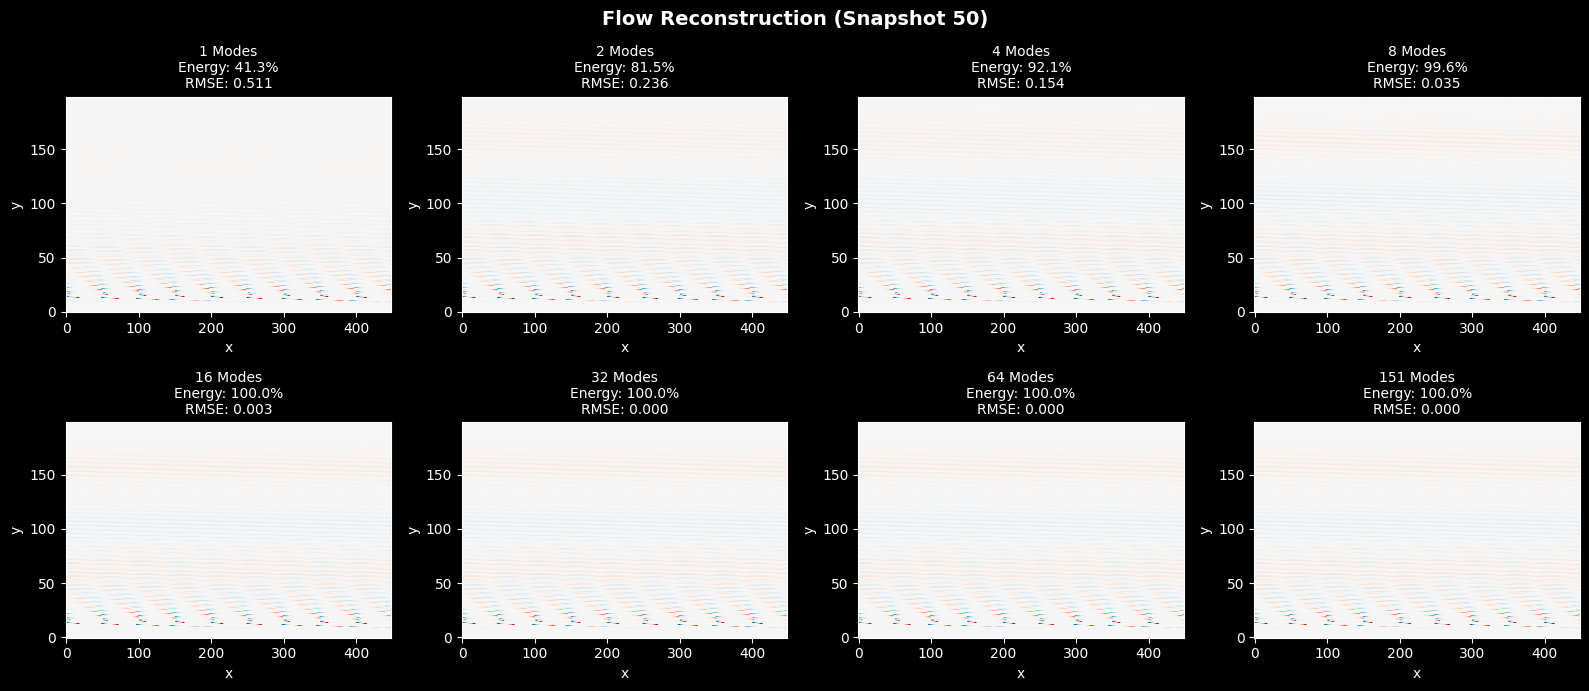


INSIGHT: Reconstruction Quality
  - 2 modes capture the MAIN vortex shedding pattern
  - 4-8 modes add harmonic details
  - 16+ modes needed for fine wake structures


In [13]:
# Reconstruct flow with different number of modes
snapshot_idx = 50  # Pick a representative snapshot
original = VORTALL[:, snapshot_idx].reshape(ny, nx)

mode_counts = [1, 2, 4, 8, 16, 32, 64, n_modes_total]
mode_counts = [m for m in mode_counts if m <= n_modes_total]

fig, axes = plt.subplots(2, 4, figsize=(16, 7))
fig.suptitle(f'Flow Reconstruction (Snapshot {snapshot_idx})', fontsize=14, fontweight='bold')

for ax, n in zip(axes.flat, mode_counts):
    rec = pod.reconstruct(n_modes=n)
    rec_field = rec[snapshot_idx].reshape(ny, nx)
    error = np.sqrt(np.mean((original - rec_field)**2))
    energy = pod.cumulative_energy[n-1] * 100
    
    vmax = np.abs(original).max()
    ax.imshow(rec_field, cmap='RdBu_r', aspect='auto',
              vmin=-vmax, vmax=vmax, origin='lower')
    ax.set_title(f'{n} Modes\nEnergy: {energy:.1f}%\nRMSE: {error:.3f}', fontsize=10)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.tight_layout()
plt.show()

print('\nINSIGHT: Reconstruction Quality')
print(f'  - 2 modes capture the MAIN vortex shedding pattern')
print(f'  - 4-8 modes add harmonic details')
print(f'  - 16+ modes needed for fine wake structures')

## 6. Summary and Conclusions

In [14]:
print('='*70)
print('     POD ANALYSIS OF VON KARMAN VORTEX STREET - SUMMARY')
print('='*70)

print(f'''\n
DATASET:
  Source: Real CFD simulation (Brunton & Kutz textbook)
  Physics: Flow past cylinder, Re ~ 100
  Grid: {nx} x {ny} = {n_points:,} spatial points
  Snapshots: {n_snapshots} time instances

POD RESULTS:
  Total modes: {n_modes_total}
  Mode 1 energy: {pod.energy_per_mode[0]*100:.1f}%
  Mode 2 energy: {pod.energy_per_mode[1]*100:.1f}%
  Modes 1+2: {pod.cumulative_energy[1]*100:.1f}% (dominant vortex shedding)
  
  Modes for 90% energy: {n_90}
  Modes for 95% energy: {n_95}
  Modes for 99% energy: {n_99}

KEY PHYSICAL INSIGHTS:
  1. Vortex shedding is LOW-DIMENSIONAL (~2 modes capture most energy)
  2. Modes 1 & 2 form a TRAVELING WAVE (90-degree phase shift)
  3. Phase portrait reveals LIMIT CYCLE dynamics
  4. Frequency spectrum shows STROUHAL shedding frequency

APPLICATIONS:
  - Reduced-order modeling for flow control
  - Real-time flow prediction
  - Data compression ({(1 - n_95/n_modes_total)*100:.0f}% reduction with 95% accuracy)
  - Vortex-induced vibration prediction
''')

print('='*70)

     POD ANALYSIS OF VON KARMAN VORTEX STREET - SUMMARY


DATASET:
  Source: Real CFD simulation (Brunton & Kutz textbook)
  Physics: Flow past cylinder, Re ~ 100
  Grid: 449 x 199 = 89,351 spatial points
  Snapshots: 151 time instances

POD RESULTS:
  Total modes: 151
  Mode 1 energy: 41.3%
  Mode 2 energy: 40.2%
  Modes 1+2: 81.5% (dominant vortex shedding)
  
  Modes for 90% energy: 4
  Modes for 95% energy: 5
  Modes for 99% energy: 7

KEY PHYSICAL INSIGHTS:
  1. Vortex shedding is LOW-DIMENSIONAL (~2 modes capture most energy)
  2. Modes 1 & 2 form a TRAVELING WAVE (90-degree phase shift)
  3. Phase portrait reveals LIMIT CYCLE dynamics
  4. Frequency spectrum shows STROUHAL shedding frequency

APPLICATIONS:
  - Reduced-order modeling for flow control
  - Real-time flow prediction
  - Data compression (97% reduction with 95% accuracy)
  - Vortex-induced vibration prediction



## 7. References

1. **Lumley, J.L.** (1967) "The structure of inhomogeneous turbulent flows" - *Original POD formulation*

2. **Sirovich, L.** (1987) "Turbulence and the dynamics of coherent structures" - *Snapshot POD method*

3. **Brunton, S.L. & Kutz, J.N.** (2019) *Data-Driven Science and Engineering* - **Dataset source**

4. **Roshko, A.** (1954) "On the development of turbulent wakes from vortex streets" - *Von Karman vortex physics*

---

**Note**: This analysis used REAL computational fluid dynamics data, demonstrating how POD extracts meaningful physical structures from complex flow fields.